### **Ridefinizione del Progetto**

Il progetto si evolve in una pipeline duale che combina due approcci distinti per l'elaborazione di documenti scientifici su ArXiv, uno focalizzato sull'information retrieval multimodale per il QA e l'altro orientato alla creazione e utilizzo di un grafo per il reasoning avanzato. Ecco una sintesi della nuova struttura:

---

### **1. Obiettivo Generale**
Creare un Google Colab notebook che esplora due metodi distinti:
1. **Approccio Multimodale per il QA**: Retrieval di contenuti (testo e visivi) da documenti ArXiv con valutazione quantitativa delle prestazioni su un task di multiple-choice QA.
2. **GraphRAG per Reasoning Avanzato**: Creazione e utilizzo di un grafo di conoscenza a partire da documenti ArXiv per rispondere a domande complesse (multi-hop reasoning e aggregazioni) attraverso tecnologie avanzate.

---


### **2. Descrizione dei Due Moduli**

#### **Modulo 1: Approccio Multimodale per QA**
- **Focus**: Estrarre chunk di testo e figure dai PDF, utilizzarli in pipeline di retrieval (multimodale e text-only), e valutarli quantitativamente in un task di QA multiple-choice.
- **Tecnologie**:
  - Modelli multimodali (es. ColQwen2).
  - Late interaction per text-only retrieval.
  - Metriche di valutazione come Precision@k, MRR e accuratezza downstream su QA.
- **Output**:
  - Risultati numerici sulle prestazioni dei vari approcci.
  - Tabelle e grafici comparativi.

---

#### **Modulo 2: GraphRAG per Reasoning Avanzato**
- **Focus**: Costruire un grafo di conoscenza a partire dai documenti ArXiv (estrazione di entità e relazioni) per rispondere a domande complesse.
- **Pipeline**:
  1. **Estrazione di Entità e Relazioni**:
     - Uso di LLM (es. GPT-4o-mini) per identificare nodi e archi, con varianti per aggiungere forza relazionale o descrizioni.
  2. **Popolazione del Grafo**:
     - Archiviazione in un database Neo4j per interrogazioni successive.
  3. **Interrogazione del Grafo**:
     - Approcci:
       - Vicini diretti di entità.
       - Community detection e clustering.
       - Generazione di query Cypher con un LLM.
  4. **Reasoning e Risposta**:
     - Generazione di risposte condizionate da cluster di entità.
     - Combina risposte locali e globali con pesi stimati.
- **Tecnologie**:
  - **Neo4j** per graphDB.
  - **Milvus** per indicizzazione come VectorDB.
  - **LangGraph** per pipeline automatizzata.
- **Output**:
  - Demo interattiva con domande esempio.
  - Visualizzazioni di query sul grafo e risposte.

---

### **3. Struttura del Notebook**

#### **Parte 1: Multimodal Retrieval**

In [ ]:
!pip install datasets
!pip install pillow
!pip install matplotlib

1. **Setup**: Installazione di librerie e caricamento dataset.

In [1]:
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt

/home/dl.net/rgiordano/projects/MultiGraphQA/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


      @misc{li2024multimodal,
            title={Multimodal ArXiv: A Dataset for Improving Scientific Comprehension of Large Vision-Language Models}, 
            author={Lei Li and Yuqi Wang and Runxin Xu and Peiyi Wang and Xiachong Feng and Lingpeng Kong and Qi Liu},
            year={2024},
            eprint={2403.00231},
            archivePrefix={arXiv},
            primaryClass={cs.CV}
        }


In [2]:
# Load parquet files inside folder data
ds = load_dataset('parquet', data_files='data/*.parquet')

Generating train split: 500 examples [00:00, 881.71 examples/s]


In [3]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['query', 'image', 'image_filename', 'options', 'answer', 'page', 'model', 'prompt', 'source'],
        num_rows: 500
    })
})


In [4]:
ds['train'][0]

{'query': 'Based on the graph, what is the impact of correcting for fspec not equal to 1 on the surface density trend?',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1621x1191>,
 'image_filename': 'images/1810.10511_2.jpg',
 'options': "['A. Correction causes a significant increase in surface density across all radii.', 'B. Correction results in a decrease in surface density for larger radii.', 'C. Correction causes the surface density to converge with the fspec = 1 case at larger radii.', 'D. Correction does not affect the surface density trend at all.', '-']",
 'answer': 'C',
 'page': '',
 'model': 'gpt4V',
 'prompt': '',
 'source': 'arxiv_qa'}

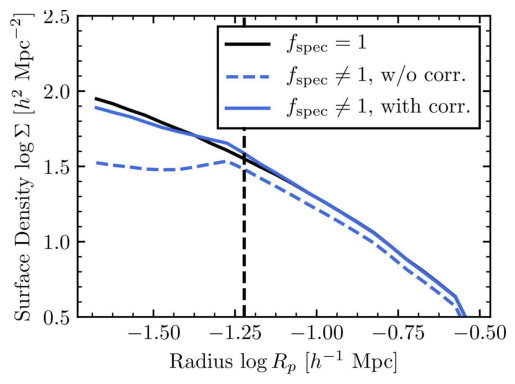

In [5]:
img=ds['train'][0]['image']
# Assuming the image is loaded as 'img'
plt.imshow(img)
plt.axis('off')  # Optional: Hides the axis
plt.show()

In [6]:
ds['train'].to_pandas().head()

,query,image,image_filename,options,answer,page,model,prompt,source
0,"Based on the graph, what is the impact of corr...",{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,images/1810.10511_2.jpg,['A. Correction causes a significant increase ...,C,,gpt4V,,arxiv_qa
1,"Based on the progression from JUL10 to FEB11Q,...",{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,images/1107.3275_2.jpg,['A) A consistent decrease in the percentage o...,D,,gpt4V,,arxiv_qa
2,What physical phenomenon could the pattern of ...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,images/quant-ph9912091_0.jpg,"['A. Diffraction patterns of light', 'B. Magne...",B,,gpt4V,,arxiv_qa
3,What is the approximate uv-distance where the ...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,images/1808.10438_2.jpg,"['A) 0 - 500 kλ', 'B) 500 - 1000 kλ', 'C) 1000...",B,,gpt4V,,arxiv_qa
4,In which subfigures does the average arrival f...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,images/cond-mat0603861_2.jpg,"['A) Subfigures (a) and (b)', 'B) Subfigures (...",A,,gpt4V,,arxiv_qa


In [4]:
from vidore_benchmark.evaluation import EvalManager as eval_mod
print(dir(eval_mod))


['__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'data', 'dataset_col', 'datasets', 'from_csv', 'from_dict', 'from_dir', 'from_json', 'from_multiple_json', 'get_df_for_dataset', 'get_df_for_metric', 'get_df_for_model', 'melt', 'melted', 'metric_col', 'metrics', 'model_col', 'models', 'sort_by_dataset', 'sort_by_metric', 'sort_columns', 'to_csv']


In [6]:
from datasets import load_dataset
from dotenv import load_dotenv
from vidore_benchmark.evaluation.evaluate import evaluate_dataset
from vidore_benchmark.retrievers.jina_clip_retriever import JinaClipRetriever

load_dotenv(override=True)


my_retriever = JinaClipRetriever("jinaai/jina-clip-v1")
dataset = load_dataset("vidore/syntheticDocQA_dummy", split="test")
metrics = evaluate_dataset(my_retriever, dataset, batch_query=4, batch_passage=4)
print(metrics)

SSLError: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /jinaai/jina-clip-v1/resolve/main/config.json (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))"), '(Request ID: 81ef6faa-b190-4341-a229-7033636e8edc)')

2. **Estrazione Contenuti**: Testo e immagini da documenti ArXiv.


3. **Implementazione Approcci**:
   - Multimodale con modelli avanzati.
   - Text-only con late interaction e late chunking.

4. **Pipeline di QA**: Risoluzione multiple-choice con un modello generativo.

5. **Valutazione**:
   - Metriche di retrieval.
   - Accuratezza su QA.

6. **Visualizzazione**: Risultati e grafici comparativi.

#### **Parte 2: GraphRAG**
1. **Setup**: Installazione librerie (Neo4j, Milvus, LangGraph).
2. **Estrazione Triple**:
   - LLM per nodi e archi.
   - Scelta tra aggiunta di forza relazionale o descrizioni.
3. **Costruzione del Grafo**:
   - Inserimento in Neo4j.
4. **Interrogazione e Reasoning**:
   - Community detection, vicini diretti, query Cypher.
   - Generazione risposte locali e globali.
5. **Demo Interattiva**:
   - Domande multi-hop con risposte strutturate.
6. **Visualizzazione**:
   - Visualizzazione del grafo e delle risposte.

---


### **4. Output Finale**
- **Modulo 1**: Report quantitativo sulle prestazioni dei modelli di retrieval nel task multimodale.
- **Modulo 2**: Grafo di conoscenza interattivo con risposte a domande complessive e reasoning complesso.